In [97]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.metrics import balanced_accuracy_score 
bmac = balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier 

from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

#%matplotlib inline
%matplotlib notebook
from matplotlib import pyplot as plt

In [12]:
X_train_file = 'X_train.csv'
y_train_file = 'y_train.csv'
X_test_file  = 'X_test.csv'

labels_df = pd.read_csv(y_train_file)
bare_df   = pd.read_csv(X_train_file)
test_df   = pd.read_csv(X_test_file)

bare_df.insert(0,'y',labels_df['y'])

labels_df = labels_df.set_index('id')
bare_df   = bare_df  .set_index('id')
test_df   = test_df  .set_index('id')

In [13]:
print('bare_df.shape =', bare_df.shape)
print('test_df.shape  =', test_df.shape)
print('y distribution: ')
print(bare_df['y'].value_counts())
print('We are told that \"Test set has the same class imbalance as the training set.\"')

bare_df.shape = (4800, 1001)
test_df.shape  = (4100, 1000)
y distribution: 
1    3600
2     600
0     600
Name: y, dtype: int64
We are told that "Test set has the same class imbalance as the training set."


In [14]:
def mean_std_normalise(df):
    return (df-df.mean())/df.std()

def min_max_normalise(df):
    return (2*df-df.min()-df.max())/(df.max()-df.min())

def oh(y):
    y0 = y == 0
    y1 = y == 1
    y2 = y == 2
    return np.stack((y0,y1,y2),axis=1)

In [105]:
#Normalizing and preparing feature and label matrices
nrm_df = mean_std_normalise(bare_df.drop(columns='y'))
nrm_df['y'] = bare_df['y']

In [106]:
# dividing X, y into train and test data 
df_train, df_test = train_test_split(nrm_df)

In [107]:
use_oversampling = False
X_train = None
y_train = None
weights = None
if use_oversampling:
#Oversampling the training set only
    # Class count
    count_1, count_2, count_0 = df_train['y'].value_counts()

    # Divide by class
    df_0 = df_train[df_train['y'] == 0]
    df_1 = df_train[df_train['y'] == 1]
    df_2 = df_train[df_train['y'] == 2]
    # Let's try balancing out the classes with over-sampling
    df_0_over = df_0.sample(count_1, replace=True)
    df_2_over = df_2.sample(count_1, replace=True)
    over_df = pd.concat([df_0_over, df_1, df_2_over], axis=0)
    # I expect this to be bigger, count1*3 = 10800
    over_df.shape

    # so, BMAC didn't change, but we also made a mistake
    # we should be oversampling on the test set too
    # what to expect? if we get better will BMAC reward us for well handled class imbalance?
    # Does NB classifier even care about sample repetitions? 
    # I think yes
    X_train = over_df.drop(columns='y').values
    y_train = over_df['y'].values
    weights = {0:1, 1:1, 2:1}
else:
    X_train = df_train.drop(columns='y').values
    y_train = df_train['y'].values
    weights={0:1/.125, 1:1/.75, 2:1/.125}
    
n_train = len(y_train)

X_test = df_test.drop(columns='y').values
y_test = df_test['y'].values
n_test = len(y_test)
print("train shape = ", np.shape(X_train))
print("test shape  = ", np.shape(X_test))
print()
print('n0test = %.1f%%'%(100/n_test*np.sum((y_test == 0))))
print('n1test = %.1f%%'%(100/n_test*np.sum((y_test == 1))))
print('n2test = %.1f%%'%(100/n_test*np.sum((y_test == 2))))
print()
print('n0train = %.1f%%'%(100/n_train*np.sum((y_train == 0))))
print('n1train = %.1f%%'%(100/n_train*np.sum((y_train == 1))))
print('n2train = %.1f%%'%(100/n_train*np.sum((y_train == 2))))
print()

train shape =  (3600, 1000)
test shape  =  (1200, 1000)

n0test = 11.9%
n1test = 76.6%
n2test = 11.5%

n0train = 12.7%
n1train = 74.5%
n2train = 12.8%



In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
 #Initialize with whatever parameters you want to

rfc100 = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight=weights)
# 10-Fold Cross validation
print(np.mean(cross_val_score(rfc100, X_train, y_train, cv=10)))

print('Fitted')
rfc100_pred  = rfc100.predict(X_test)
print('Plain predictions')
print('test  BMAC =', bmac(y_test, rfc100_pred))
rfc100_train = rfc100.predict(X_train)
print('train BMAC =', bmac(y_train, rfc100_train))

0.7791645496510553
Fitted


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [136]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

abc100 = AdaBoostClassifier(n_estimators=100)
abc100.fit(X_train, y_train)  

print('Fitted')
abc100_pred  = abc100.predict(X_test)
print('Plain predictions')
print('test  BMAC =', bmac(y_test, abc100_pred))
abc100_train = abc100.predict(X_train)
print('train BMAC =', bmac(y_train, abc100_train))


TypeError: __init__() got an unexpected keyword argument 'class_weight'

In [134]:

abc100.feature_importances_  

abc100.score(X_train, y_train)  

0.8413888888888889

In [108]:
from sklearn.svm import SVC 

In [120]:
rbf1 = SVC(gamma='scale', class_weight=weights, kernel = 'rbf', C = 1)
rbf1 = rbf1.fit(X_train, y_train)
print('Fitted')
rbf1_pred  = rbf1.predict(X_test)
print('Plain predictions')
print('test  BMAC =', bmac(y_test, rbf1_pred))
rbf1_train = rbf1.predict(X_train)
print('train BMAC =', bmac(y_train, rbf1_train))

Fitted
Plain predictions
test  BMAC = 0.6466618099063574
train BMAC = 0.9802644483929512


In [122]:
print('Argmax predictions')
rbf1_pred_prob  = rbf1.decision_function(X_test)
print('test  BMAC =', bmac(y_test, np.argmax(rbf1_pred_prob, axis=1)))
rbf1_train_prob = rbf1.decision_function(X_train)
print('train BMAC =', bmac(y_train, np.argmax(rbf1_train_prob, axis=1)))

Argmax predictions
test  BMAC = 0.6455878600695746
train BMAC = 0.9805131118269933


<IPython.core.display.Javascript object>


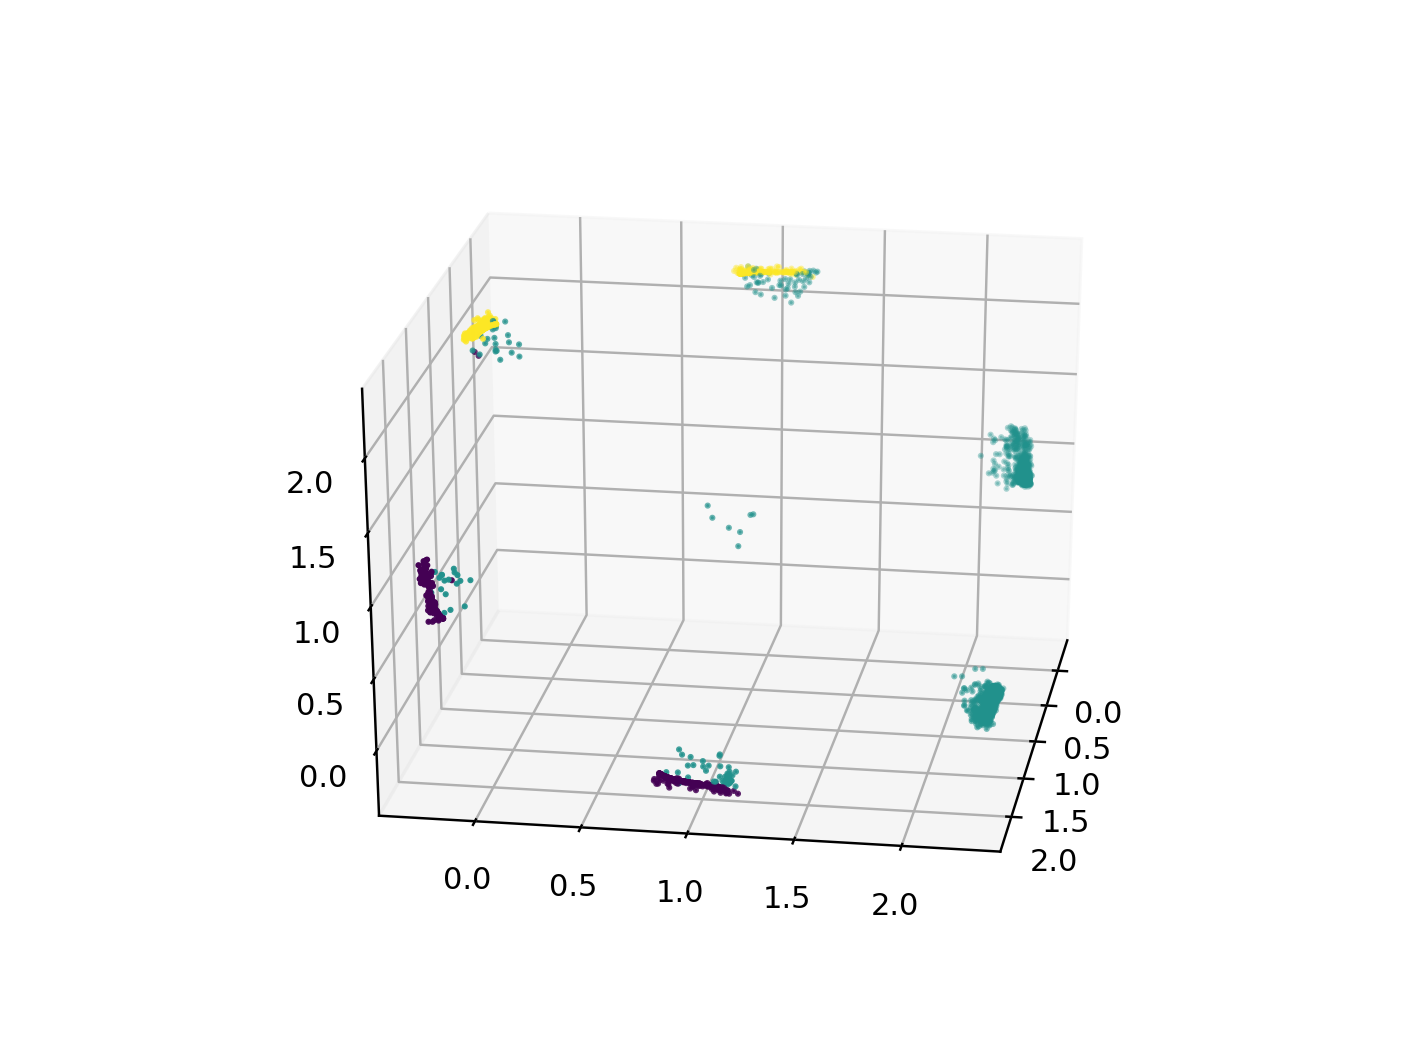

<IPython.core.display.Javascript object>


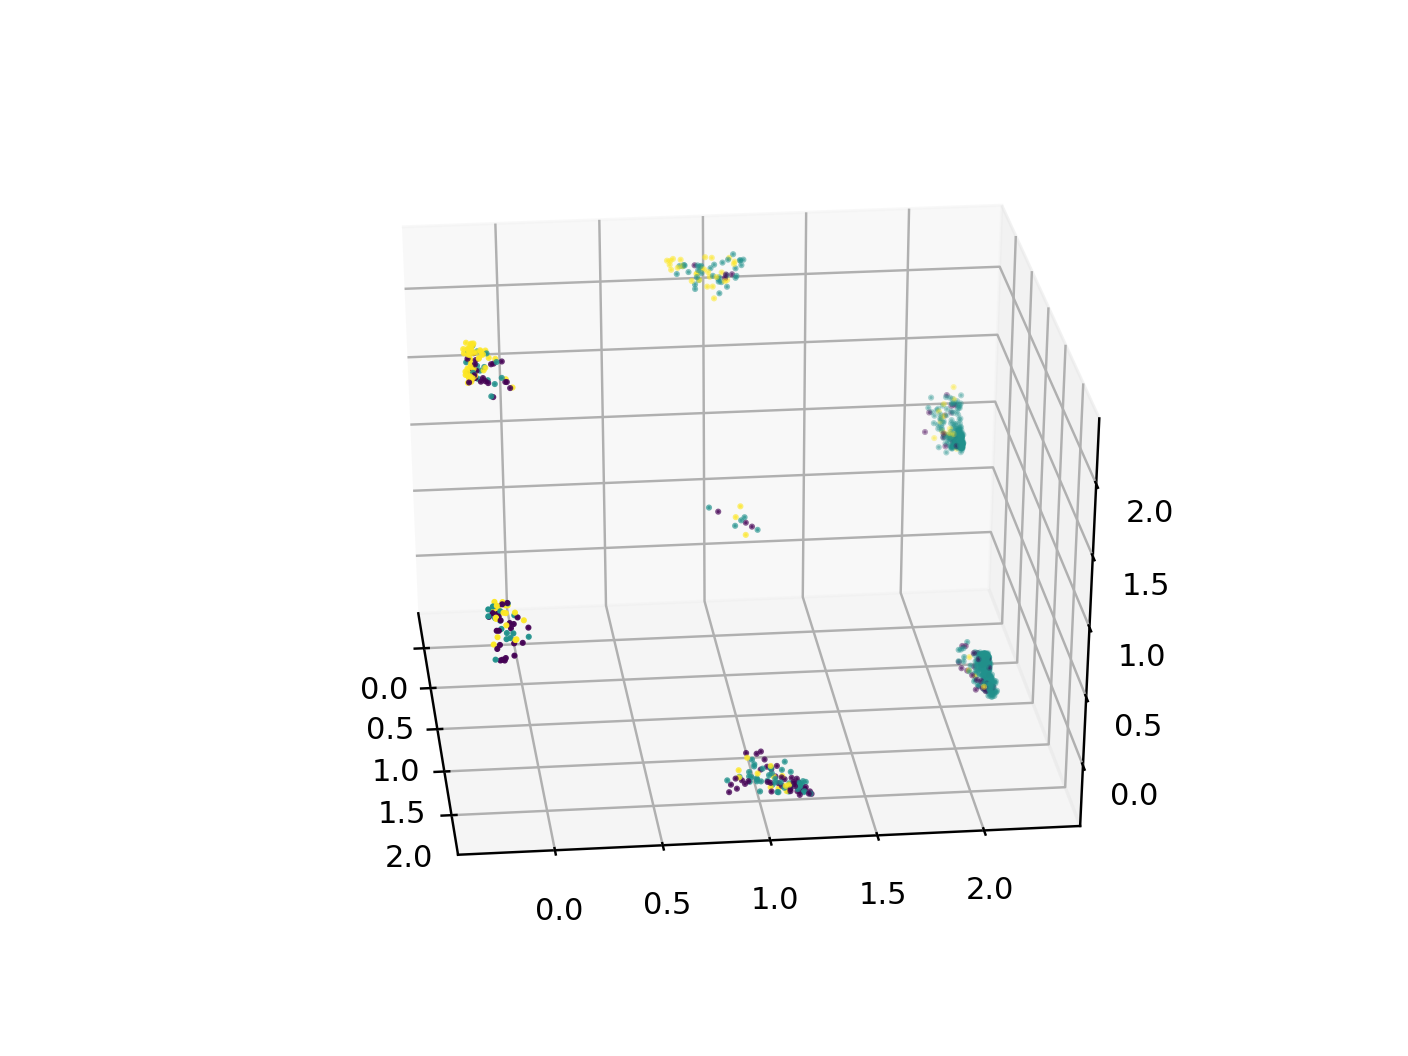

In [130]:
# samples it can't confidently classify are in the middle

from mpl_toolkits.mplot3d import Axes3D
ax1 = plt.figure().add_subplot(111, projection='3d')
ax2 = plt.figure().add_subplot(111, projection='3d')
ax1.scatter(rbf1_train_prob[:,0], rbf1_train_prob[:,1], rbf1_train_prob[:,2], c=y_train,s=1)
ax2.scatter(rbf1_pred_prob[:,0], rbf1_pred_prob[:,1], rbf1_pred_prob[:,2], c=y_test, s=1)

In [119]:
rbf100 = SVC(gamma='scale',class_weight=weights, kernel = 'rbf', 
          C = 1.00, decision_function_shape='ovo')
rbf100 = rbf.fit(X_train, y_train)
print('Fitted')
rbf100_pred  = rbf.predict(X_test)
print('test  BMAC =', bmac(y_test, rbf100_pred))
rbf100_train = rbf.predict(X_train)
print('train BMAC =', bmac(y_train, rbf100_train))

Fitted
test  BMAC = 0.600374866022782
train BMAC = 1.0


In [33]:
w = {0:1/.125, 1:1/.75, 2:1/.125}

In [42]:
np.array([*w.values()])


array([0, 1, 2])

In [ ]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
#digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(y_train)+len(y_test)

# Set the parameters by cross-validation
tuned_parameters = [{'gamma': [1e-3, 1e-4, 1e-5],
                     'C': [1.5, 2.5, 3, 3.5, 4]}]

clf = GridSearchCV(SVC(kernel='rbf', class_weight=weights),tuned_parameters, cv=5,
                   scoring='balanced_accuracy',
                   n_jobs=-1, verbose=15)

#tuned_parameters = [n_estimators=100,  class_weight=weights)

#clf = GridSearchCV(RandomForestClassifier(),tuned_parameters, cv=5,
#                   scoring='balanced_accuracy',
#                   n_jobs=-1, verbose=10)


clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

clf_pred  = clf.predict(X_test)
print('Plain predictions')
print('test  BMAC =', bmac(y_test, clf_pred))
clf_train = clf.predict(X_train)
print('train BMAC =', bmac(y_train, clf_train))

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
print(classification_report(y_test, clf_pred))
print()




Automatically created module for IPython interactive environment
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 